# Testing Facenet for Bias in Facial Recognition
### By Rufaida Khan, Julissa Mota, and Gazi Rahman

### Preamble

Advancements in the field of audiovisual machine learning have led to the rise of facial recognition technology in law enforcement in the United States of America. Companies like [Clearview AI](https://www.clearview.ai) have offered products that allow government agencies to recognize the individuals that appear in security camera footage. After anecdotes arose where Black Americans were falsely imprisoned for crimes another Black suspect committed ([like this story, for example](https://www.nbcnews.com/news/us-news/detroit-woman-sues-city-falsely-arrested-8-months-pregnant-due-facial-rcna98447)), critics called into question the ethics of using facial recognition in law enforcement. [Groups]((https://naacp.org/resources/artificial-intelligence-predictive-policing-issue-brief)) have hypothesized that these AI algorithms may demonstrate biases based on demographic information. If this is true, then accepting the use of facial recognition software would truly be unethical, as it would mean accepting the imposition of disproportionate negative consequences (false imprisonment) on some groups over others, qualifying as discrimination. Our team will test this assertion in this Jupyter Notebook and discuss the implications in our accompanying writeup. We will be testing [Facenet](https://arxiv.org/abs/1503.03832), an open-source, highly performant facial analysis model created by Google-affiliated researchers. We will be using the [Chicago Faces Database](https://www.chicagofaces.org) to test the model for algorithmic bias based on race and sex. This project is one conducted for the final assignment of Wesleyan's Comp334: Information Security.

### Loading modules
Among our modules we will use...
- `os` to compile our dataset
- `pandas` to keep track of our analysis
- `tqdm` to create loading bars
- `PIL.Image` to load images
- `facenet_pytorch` to detect, crop, align, and generate embeddings for face images
- `numpy` to compare face embeddings and calculate similarities
- `sklearn.metrics` to assess the model
- `matplotlib.pyplot` and `seaborn` to generate plots
- `scipy.stats` to perform statistical tests

In [1]:
# data processing
import os
import pandas as pd
from tqdm import tqdm

# facial recognition
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
import numpy as np

# data analysis
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

### Preparing the Data

The Chicago Face Database is a collection of images of survey participants who elected to have their faces photographed with various expressions and self-identified with their race and sex. It contains directories that pertain to participants, and those directories contain images of the respective participant. The directory names identify the participant based on `[race][sex]-[number]`, where the number is unique to the demographic group. Thus, `BF-001` identifies Black Female #1 and `WM-001` identifies White Male #1. Image names follow a similar naming structure, albeit also containing the expression the participant is making in the photo. Some participants may have multiple images of their face. While there are 1207 images of 597 individuals split among Asian, Black, Latino, and White participants, we have omitted Asian and Latino participants since these demographics do not contain individuals who had multiple photos taken of them. We need at least some participants to have multiple photos of themselves in order to test the face recognition algorithm effectively. Thus, our study is constricted to 990 images of 380 individuals split among 104 Black Females, 93 Black Males, 90 White Females, and 93 White Males.

In [2]:
# load dataset directory
data_path = '/Users/gazirahman/coursework/comp334/project/algorithmic_bias/CFD'
participant_dirs = sorted(os.listdir(data_path))

# walk through each sub-directory, compiling information
participant_id = []
img_id = []
race = []
sex = []
for dir_name in participant_dirs:

    # skip irrelevant files/directories
    if dir_name == '.DS_Store' or dir_name == 'Icon\r':
        continue

    # for each sub-directory, fetch contents; for each image, parse image name for information
    img_list = os.listdir(f"{data_path}/{dir_name}")
    for img_name in img_list:

        if img_name == '.DS_Store' or img_name == 'Icon\r':
            continue
        
        participant_id.append(dir_name)
        img_id.append(img_name)
        attributes = img_name.split('-')
        race.append(attributes[1][0])
        sex.append(attributes[1][1])

# clean up data, create dataframe
race = ['Asian' if label == 'A' else 'Black' if label == 'B' else 'Latino' if label == 'L' else 'White' for label in race]
sex = ['Female' if label == 'F' else 'Male' for label in sex ]
overall_df = pd.DataFrame({'participant_id': participant_id, 'img_id': img_id, 'race': race, 'sex': sex})

# constrict data and fetch overview
df = overall_df[overall_df['race'].isin(['White', 'Black'])]
demographics = df.drop(columns='img_id').groupby('participant_id').agg({'race': 'first', 'sex': 'first'}).reset_index()
display(demographics[['race','sex']].value_counts())
display(df)

race   sex   
Black  Female    104
       Male       93
White  Male       93
       Female     90
Name: count, dtype: int64

,participant_id,img_id,race,sex
109,BF-001,CFD-BF-001-026-A.jpg,Black,Female
110,BF-001,CFD-BF-001-018-HO.jpg,Black,Female
111,BF-001,CFD-BF-001-009-F.jpg,Black,Female
112,BF-001,CFD-BF-001-025-N.jpg,Black,Female
113,BF-001,CFD-BF-001-021-HC.jpg,Black,Female
...,...,...,...,...
1202,WM-254,CFD-WM-254-152-N.jpg,White,Male
1203,WM-255,CFD-WM-255-219-N.jpg,White,Male
1204,WM-256,CFD-WM-256-138-N.jpg,White,Male
1205,WM-257,CFD-WM-257-161-N.jpg,White,Male


### Generating Embeddings

Embeddings are quantitative vectors representing qualitative information; for facial analysis algorithms, linear algebra and geometric analysis techniques are used to quantify the face. For example, an algorithm takes an image of your face, detects your eyes, nose, and mouth, and for each feature it categorizes them into 1 of 10 eyes/nose/mouth archetypes. Suppose it outputs the vector <3,4,5>, indicating that your eyes fit category 3, nose fits category 4, and lips fit category 5. Now, one can build a facial recognition software into a phone that uses this algorithm and these reference embeddings every next time someone tries to log into the phone to make sure it really is you. The software would simply snap a photo of the user, generate embeddings for the face, and compare to the reference embeddings. Embeddings that belong to the same person will not always be the exact same; suppose you try to use your phone first thing in the morning when your eyes are puffier, placing them into category 4 and making your embeddings <4,4,5>. We can calculate the distance between the reference embeddings and new embeddings and affirm that sure, with a value of 1 the euclidian distance is close enough for these embeddings to point to the same person. While there may be variation in embeddings per use, the algorithm and vector space should be nuanced enough that despite these error ranges, when embeddings are generated for a new person entirely, the embeddings reflect the difference in features. Maybe a doppelganger with a slightly bigger nose and wider lips tries to use your phone; their face embeddings are <3,5,6>. The distance between their embeddings and your reference embeddings is ~1.41; we can declare that a distance greater than 1 indicates a mismatch in faces, disallowing them from accessing your phone.

Industry standard facial recognition algorithms are much more sophisticated than this. In this project, we will be using Facenet as trained on the [VGGFace2](https://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) dataset, which was measured to have an accuracy of 99.65%. Facenet generates embeddings that are vectors with 512 dimensions as opposed to our 3. While our values are quantized and limited to a select number of options per element, Facenet's elements are continuous and each element can be one of an infinite number of options. Ideally, this should introduce enough nuance to ensure that face embeddings are relatively unique with respect to the owner of the face; that is to say embeddings of different photos of a given person are close enough to distinguish them from embeddings of photos of another person.

In [3]:
# load facenet, a facial analysis algorithm created by google researchers, pre-trained on the vggface2 dataset
# load MTCNN, a tool used to detect and crop faces in images
resnet = InceptionResnetV1(pretrained='vggface2').eval()
mtcnn = MTCNN()

# get_embedding(image_path): loads the image stored at image_path; fetches each face in the image and generates embeddings for them
def get_embedding(image_path):
    img = Image.open(image_path)
    aligned = mtcnn(img)

    # generate embedding only if a face was detected
    if aligned is not None:

        aligned = aligned.unsqueeze(0)
        embedding = resnet(aligned).detach().numpy() 
        return embedding
    
    return None

# create lookup table with the embeddings for every image
embeddings = {}
for i in tqdm(range(len(df)), desc="Computing embeddings"):
    img_path = f"{data_path}/{df.iloc[i]['participant_id']}/{df.iloc[i]['img_id']}"
    embeddings[i] = get_embedding(img_path)

Computing embeddings: 100%|██████████| 990/990 [05:27<00:00,  3.02it/s]


### Face Recognition

For the core of this project, we will be comparing every image in the dataset to every other image. We will do a pairwise analysis where we select two different images, fetch the embeddings for each, calculate the distance between the embeddings, and determine whether the distance is less than 1 (as is convention with this model). If the distance is less than 1, then the model will have predicted that the two images belong to the same person; if the distance is greater, the model will have predicted that the images reflect different people. We will store the data on the participants, the images, the prediction, and a label that reflects whether or not the two images really do belong to the same participant. By tracking the race and sex of each participant, we will be able to track how the results vary per demographic.

In [4]:
# track information for each participant/image
participant1, participant2 = [], []
img1, img2 = [], []
race1, race2 = [], []
sex1, sex2 = [], []
distance, label, prediction = [], [], []

# convert dataframe to numpy array for speed of computation
df_array = df.to_numpy()

# compare every image with every other image to check for similarity, tracking whether they really are similar and what the model predicts
for i in tqdm(range(len(df)), desc="Processing image pairs"):
    for j in range(i+1, len(df)):
        
        embedding1 = embeddings[i]
        embedding2 = embeddings[j]

        # calculate distance only if embeddings were created (can't compare <1,2,3> and None)
        if embedding1 is not None and embedding2 is not None:

            dist = np.linalg.norm(embedding1 - embedding2)
            pred = dist < 1.0

            # store data
            participant1.append(df_array[i, 0])
            participant2.append(df_array[j, 0])
            img1.append(df_array[i, 1])
            img2.append(df_array[j, 1])
            race1.append(df_array[i, 2])
            race2.append(df_array[j, 2])
            sex1.append(df_array[i, 3])
            sex2.append(df_array[j, 3])
            distance.append(dist)
            label.append(df_array[i, 0] == df_array[j, 0])
            prediction.append(pred)

Processing image pairs: 100%|██████████| 990/990 [00:01<00:00, 732.34it/s]


### Surface Level Results

Overall Accuracy: 97.85%
Rate of true positives: 99.93%
Rate of false positives: 2.16%
Rate of false negatives: 0.07%
Rate of true negatives: 97.84%


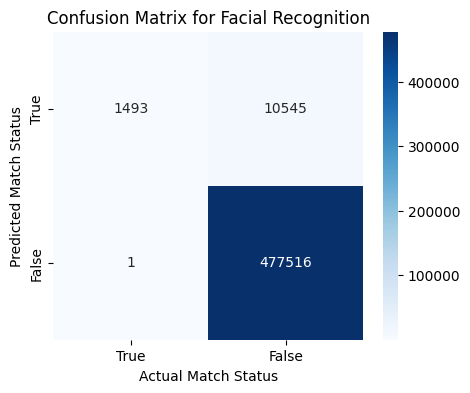

In [5]:
# compile comparison data and demonstrate overall results
results = pd.DataFrame({'participant1': participant1, 'participant2': participant2, 'img1': img1, 'img2': img2, 'race1': race1, 'race2': race2, 'sex1': sex1, 'sex2': sex2, 'distance': distance, 'label': label, 'prediction': prediction})

# create a confusion matrix comparing the actual labels for each image pair to the model prediction
# calculate accuracies per performance category
overall_cm = confusion_matrix(results['label'], results['prediction'], labels = [True, False]).T
accuracy = accuracy_score(results['label'], results['prediction'])
print(f'Overall Accuracy: {(round(accuracy * 10000) / 100)}%')
print(f'Rate of true positives: {round((overall_cm[0][0] / (overall_cm[0][0] + overall_cm[1][0])) * 10000 ) / 100}%')
print(f'Rate of false positives: {round((overall_cm[0][1] / (overall_cm[0][1] + overall_cm[1][1])) * 10000 ) / 100}%')
print(f'Rate of false negatives: {round((overall_cm[1][0] / (overall_cm[0][0] + overall_cm[1][0])) * 10000 ) / 100}%')
print(f'Rate of true negatives: {round((overall_cm[1][1] / (overall_cm[0][1] + overall_cm[1][1])) * 10000 ) / 100}%')

# create heatmap for visualization
plt.figure(figsize=(5,4))
sns.heatmap(overall_cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['True', 'False'], yticklabels = ['True', 'False'])
plt.title(f'Confusion Matrix for Facial Recognition')
plt.xlabel('Actual Match Status')
plt.ylabel('Predicted Match Status')
plt.show()

After compiling the results, we see that the model had an overall accuracy of 97.85%. While this is lower than the performance measured with VGGFace2 (99.65%), we did not find it to be a difference remarkable enough to warrant investigation; this could just be attributed to small differences in the dataset rather than a reflection of the model itself. The heatmap illustrates a frequency count of how many image pairs aligned and disaligned in terms of the actual label and the model's predicted label. That is, true positives on the top left (the model accurately labels a match those pairs that are truly matches), false positives on the top right (the model inaccurately labels a match those pairs that are not matches), false negatives on the bottom left (the model inaccurately labels not a match for those values that are matches), and true negatives on the bottom right (the model accurately labels not a match for those values that are not a match). True positives and true negatives demonstrate the model performing as intended, accurately determining whether image pairs belong to the same person. The relatively low number of true positives is not a reflection of poor performance; this is a natural consequence of the fact that more image pairs not a match than are a match. Intuitively, if we took 2 images each of 50 people, the nature of this type of study makes it such that more images are dissimilar than similar. For each of the 50 people, their images could only match with each other, making 50 possible true positives. However, each image would be true negatives with all 49 other people, each of whom have 2 images, making it such that each person's image is dissimilar with 98 images. Since there are 2 images per person and 50 people, this makes 9800 true negatives. While we've condensed the math for simplicity, a similar manner can be used to explain the low scale of true positives in this study. 

The heatmap demonstrates that the total number of image pairs that were matches is 1494; among these matches, only 1 pair was inaccurately predicted as being not a match. This indicates that the model has high efficacy in accurately recognizing true matches. It has an accuracy of 99.93% for true positives. However, it also demonstrates that there were 488061 image pairs that were not matches. Among them, the model inaccuractely predicted 10545 not matching images (hereby referred to as unmatches) as being matching. This means that the model falters in accurately labeling image pairs that do not belong to the same person; it has a penchant for misidentifying faces by assuming positive when the true value is negative. Its accuracy for true negatives is 97.84%.

The overall results do not paint a complete picture regarding the performance of the model. This performance is not uniform for every individual subjected to this software.

### Deeper Analysis: Participant Race

Accuracy for Black Individuals: 92.73%
Rate of true positives: 100.0%
Rate of false positives: 7.32%
Rate of true negatives: 92.68%
Rate of false negatives: 0.0%


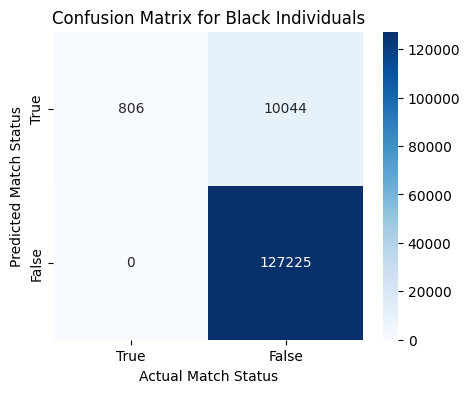

Accuracy for White Individuals: 99.59%
Rate of true positives: 99.85%
Rate of false positives: 0.41%
Rate of true negatives: 99.59%
Rate of false negatives: 0.15%


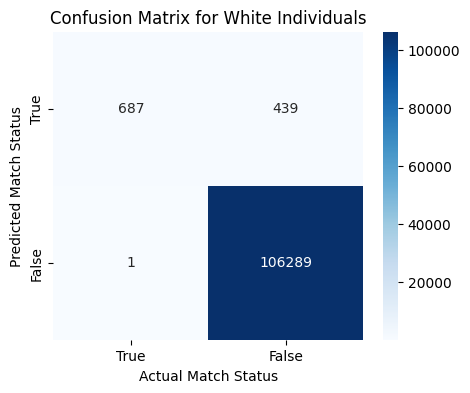

Chi-square test statistic: 6962.203578747022, p-value: 0.0


In [6]:
# for each race (black and white), we will calculate the group's own confusion matrix, accuracies and heat map
races = results['race1'].unique()
accuracy_by_race = {}
confusion_matrices = {}
for race in races:

    # isolate data to only the participants of a given race
    race_results = results[results['race1'] == race]
    race_results = race_results[race_results['race2'] == race]

    cm = confusion_matrix(race_results['label'], race_results['prediction'], labels = [True, False]).T
    accuracy = accuracy_score(race_results['label'], race_results['prediction'])
    accuracy_by_race[race] = accuracy
    confusion_matrices[race] = cm

    print(f'Accuracy for {race} Individuals: {(round(accuracy * 10000) / 100)}%')
    print(f'Rate of true positives: {round((cm[0][0] / (cm[0][0] + cm[1][0])) * 10000 ) / 100}%')
    print(f'Rate of false positives: {round((cm[0][1] / (cm[0][1] + cm[1][1])) * 10000 ) / 100}%')
    print(f'Rate of true negatives: {round((cm[1][1] / (cm[0][1] + cm[1][1])) * 10000 ) / 100}%')
    print(f'Rate of false negatives: {round((cm[1][0] / (cm[0][0] + cm[1][0])) * 10000 ) / 100}%')
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'False'], yticklabels=['True', 'False'])
    plt.title(f'Confusion Matrix for {race} Individuals')
    plt.xlabel('Actual Match Status')
    plt.ylabel('Predicted Match Status')
    plt.show()

# create contingency table for chi square test
false_positives_black = results[(results['race1'] == 'Black') & (results['race2'] == 'Black') & (results['label'] == False) & (results['prediction'] == True)].shape[0]
true_negatives_black = results[(results['race1'] == 'Black') & (results['race2'] == 'Black') & (results['label'] == False) & (results['prediction'] == False)].shape[0]
false_positives_white = results[(results['race1'] == 'White') & (results['race2'] == 'White') & (results['label'] == False) & (results['prediction'] == True)].shape[0]
true_negatives_white = results[(results['race1'] == 'White') & (results['race2'] == 'White') & (results['label'] == False) & (results['prediction'] == False)].shape[0]
contingency_table = np.array([
    [false_positives_black, true_negatives_black],
    [false_positives_white, true_negatives_white]
])

# perform statistical test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square test statistic: {chi2}, p-value: {p}")

After splitting the results such that both images in each image pair pertain to the same race, we can confirm that the performance of the model varies based on this demographic factor. The model exhibits an accuracy of 92.73% when recognizing Black people and 99.59% accuracy for White people. In the context of law enforcement, this means the model would rightfully serve justice for white people 99.59% of the time but only 92.73% of the time for Black people. Delving deeper, the model is able to correctly identify matching faces 100% of the time for Black people and 99.85% of the time for White people. Given that the discrepancy is only caused by a single incorrectly predicted value, we would assert that this difference is not remarkable. However, there is a remarkable discrepancy in the model's ability to accurately gauge when two images belong to different people. For Black people, the model correctly determines that two images are of different people only 92.68% of the time, whereas it does so 99.59% of the time for White people. In the context of law enforcement, this implies that when using Facenet to identify criminals in surveillance footage, the model would misidentify Black suspects 7.32% of the time, leading to the false imprisonment of a Black individual 7.32% of the time as opposed to 0.41% for White people. 

In our accompanying chi-square test, we use the number of pairs that were unmatches labeled matches (false positive) and the number of pairs that were unmatches labeled unmatches (true negative) to determine whether the difference in performance is statistically significant. With a p-value of 0.0, this portion of the study establishes that Facenet incorrectly determines two face images as the same even if they belong to different people at a statistically significant higher rate for Black people than White people. In the context of law enforcement, this would mean that using Facenet for facial recognition in law enforcement would lead to a statistically significant higher rate of false imprisonment for Black people than White people. Specifically, it would lead to false imprisonment 6.91% more often for Black people than White.

### Deeper Analysis: Participant Sex

Accuracy for Female Individuals: 94.36%
Rate of true positives: 100.0%
Rate of false positives: 5.68%
Rate of true negatives: 94.32%
Rate of false negatives: 0.0%


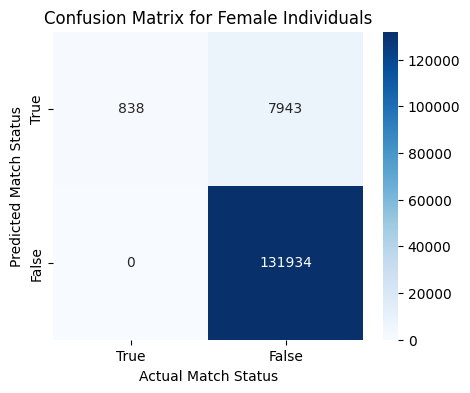

Accuracy for Male Individuals: 98.1%
Rate of true positives: 99.85%
Rate of false positives: 1.91%
Rate of true negatives: 98.09%
Rate of false negatives: 0.15%


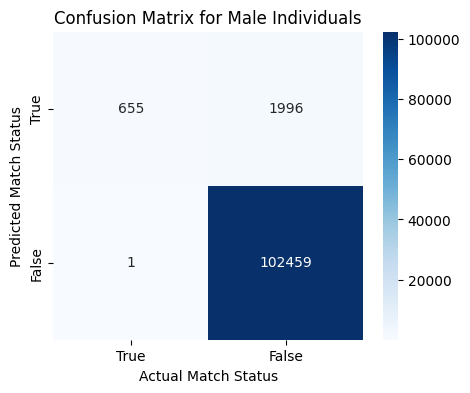

Chi-square test statistic: 2174.33296007183, p-value: 0.0


In [7]:
# for each sex (female and male), we will calculate the group's own confusion matrix, accuracies and heat map
sexes = results['sex1'].unique()
accuracy_by_sex = {}
confusion_matrices = {}
for sex in sexes:

    # isolate data to only the participants of a given sex
    sex_results = results[results['sex1'] == sex]
    sex_results = sex_results[sex_results['sex2'] == sex]

    cm = confusion_matrix(sex_results['label'], sex_results['prediction'], labels = [True, False]).T
    accuracy = accuracy_score(sex_results['label'], sex_results['prediction'])
    accuracy_by_sex[sex] = accuracy
    confusion_matrices[sex] = cm

    print(f'Accuracy for {sex} Individuals: {(round(accuracy * 10000) / 100)}%')
    print(f'Rate of true positives: {round((cm[0][0] / (cm[0][0] + cm[1][0])) * 10000 ) / 100}%')
    print(f'Rate of false positives: {round((cm[0][1] / (cm[0][1] + cm[1][1])) * 10000 ) / 100}%')
    print(f'Rate of true negatives: {round((cm[1][1] / (cm[0][1] + cm[1][1])) * 10000 ) / 100}%')
    print(f'Rate of false negatives: {round((cm[1][0] / (cm[0][0] + cm[1][0])) * 10000 ) / 100}%')

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'False'], yticklabels=['True', 'False'])
    plt.title(f'Confusion Matrix for {sex} Individuals')
    plt.xlabel('Actual Match Status')
    plt.ylabel('Predicted Match Status')
    plt.show()

# create contingency table for chi square test
false_positives_female = results[(results['sex1'] == 'Female') & (results['sex2'] == 'Female') & (results['label'] == False) & (results['prediction'] == True)].shape[0]
true_negatives_female = results[(results['sex1'] == 'Female') & (results['sex2'] == 'Female') & (results['label'] == False) & (results['prediction'] == False)].shape[0]
false_positives_male = results[(results['sex1'] == 'Male') & (results['sex2'] == 'Male') & (results['label'] == False) & (results['prediction'] == True)].shape[0]
true_negatives_male = results[(results['sex1'] == 'Male') & (results['sex2'] == 'Male') & (results['label'] == False) & (results['prediction'] == False)].shape[0]
contingency_table = np.array([
    [false_positives_female, true_negatives_female],
    [false_positives_male, true_negatives_male]
])

# perform statistical test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square test statistic: {chi2}, p-value: {p}")

After splitting the results based on sex, we can see that the model performance varies based on this demographic factor as well. As with race, the model's accuracy at truly identifying positive matches diverges for the two categories, females having 100% and males having 99.85%, based on a single mislabeled image pair, so we believe this does not warrant investigation. However, the model's performance in accurately identifying unmatches is much more noticeable, albeit less pronounced than was the case in the race groups. The model identifies false positives at a rate of 1.91% for males as opposed to a rate of 5.68% for females; used in law enforcement, this means that Facenet would lead to the false imprisonment of females 3.77% more frequently than their male counterparts. Our accompanying chi-square test confirms with confidence that this discrepancy is statistically significant, emphasizing that it holds real cause for concern.

### Deeper Analysis: Intersectionality

Performance for Black_Female:
  Accuracy: 82.23%
  True Positive Rate: 100.00%
  False Positive Rate: 17.97%
  True Negative Rate: 82.03%
  False Negative Rate: 0.00%

Performance for Black_Male:
  Accuracy: 93.33%
  True Positive Rate: 100.00%
  False Positive Rate: 6.75%
  True Negative Rate: 93.25%
  False Negative Rate: 0.00%

Performance for White_Female:
  Accuracy: 99.24%
  True Positive Rate: 100.00%
  False Positive Rate: 0.77%
  True Negative Rate: 99.23%
  False Negative Rate: 0.00%

Performance for White_Male:
  Accuracy: 99.16%
  True Positive Rate: 99.69%
  False Positive Rate: 0.85%
  True Negative Rate: 99.15%
  False Negative Rate: 0.31%



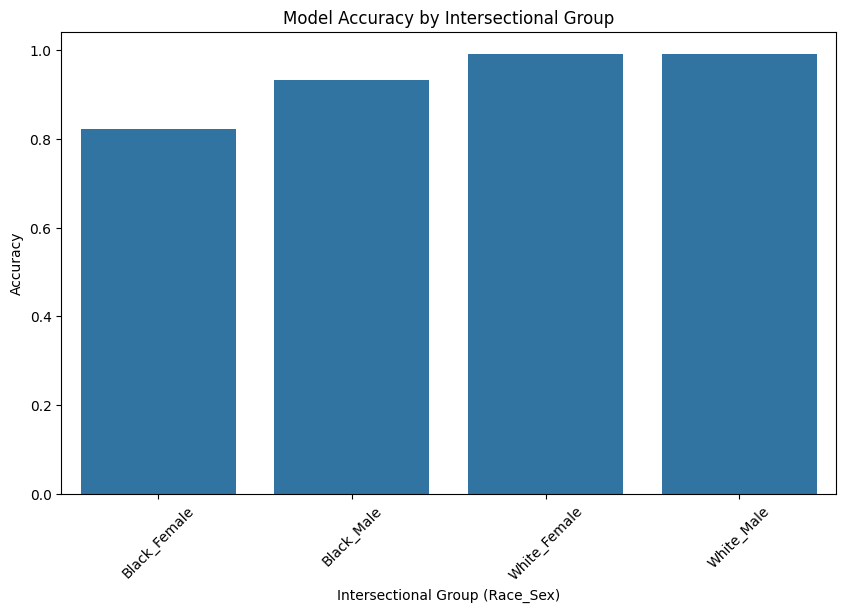

Chi-square test statistic: 3662.4656526413305, p-value: 0.0


In [14]:
# mark intersection between race and sex; fetch performance metrics for each of the 4 groups
results['intersection'] = results['race1'] + '_' + results['sex1']
intersectional_groups = results['intersection'].unique()
performance_metrics = {}
for group in intersectional_groups:
    
    # isolate results for current group
    group_results = results[(results['intersection'] == group) & (results['race2'] + '_' + results['sex2'] == group)]
    
    cm = confusion_matrix(group_results['label'], group_results['prediction'], labels=[True, False]).T
    accuracy = accuracy_score(group_results['label'], group_results['prediction'])
    
    true_positive_rate = cm[0][0] / (cm[0][0] + cm[1][0]) if (cm[0][0] + cm[1][0]) > 0 else 0
    false_positive_rate = cm[0][1] / (cm[0][1] + cm[1][1]) if (cm[0][1] + cm[1][1]) > 0 else 0
    true_negative_rate = cm[1][1] / (cm[0][1] + cm[1][1]) if (cm[0][1] + cm[1][1]) > 0 else 0
    false_negative_rate = cm[1][0] / (cm[0][0] + cm[1][0]) if (cm[0][0] + cm[1][0]) > 0 else 0
    
    # store metrics
    performance_metrics[group] = {
        'accuracy': accuracy,
        'true_positive_rate': true_positive_rate,
        'false_positive_rate': false_positive_rate,
        'true_negative_rate': true_negative_rate,
        'false_negative_rate': false_negative_rate
    }

# print performance for each group
for group, metrics in performance_metrics.items():
    print(f"Performance for {group}:")
    print(f"  Accuracy: {metrics['accuracy']:.2%}")
    print(f"  True Positive Rate: {metrics['true_positive_rate']:.2%}")
    print(f"  False Positive Rate: {metrics['false_positive_rate']:.2%}")
    print(f"  True Negative Rate: {metrics['true_negative_rate']:.2%}")
    print(f"  False Negative Rate: {metrics['false_negative_rate']:.2%}")
    print()

# plot the overall accuracy for each group as a bar chart
metrics_df = pd.DataFrame(performance_metrics).T
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_df.index, y='accuracy', data=metrics_df)
plt.title('Model Accuracy by Intersectional Group')
plt.xlabel('Intersectional Group (Race_Sex)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

# perform chi-square test
contingency_table = []
for group in intersectional_groups:
    false_positives = results[(results['intersection'] == group) & (results['label'] == False) & (results['prediction'] == True)].shape[0]
    true_negatives = results[(results['intersection'] == group) & (results['label'] == False) & (results['prediction'] == False)].shape[0]
    contingency_table.append([false_positives, true_negatives])
contingency_table = np.array(contingency_table)
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square test statistic: {chi2}, p-value: {p}")

Intersectionality denotes the interaction between different parts of one's identity; in this section we study how the intersection between race and sex may impact the model's performance among different identity groups. The model demonstrates nearly identical performance for White faces regardless of sex, having similarly high accuracy and low rates of mistakes. However, the performance falls somewhat for Black Males, whom are misidentified as the wrong person more often. Black Females remarkably have the lowest accuracy and the highest rate of false positives. This demonstrates that while the model would be similarly performance among White people, its performance is worse for Black Males and even more so for Black Females. Recontextualized into law enforcement, this demonstrates that using Facenet to recognize suspects would cause Black Females and Black Males to be falsely imprisoned at a statistically significant higher rate than each of their White counterparts.

### Conclusion

This project tested the performance of Facenet based on racial and demographic factors using the Chicago Face Database. Specifically, it tested how the performance varies among people who self-identified as Black or White and Male or Female. Our team found that Facenet experiences statistically significant differences in how it performs for these groups, especially when examining the intersection between race and sex. Thus, it confirms concerns surrounding the use of facial recognition technology in law enforcement; our study demonstrates with high confidence that individuals would face more harm based on their race and sex. In this case, the harm is false imprisonment, and the events that follow such as job loss, defamation, and damages to ones livelihood. Accepting this consequence, accepting the idea that it would be okay for some people to face more harm based on their race or their sex, qualifies as discrimination. This illustrates that it would be unethical to use facial recognition in law enforcement.

Among possible improvements, this study could be redone with a larger sample size of face images. Our team struggled to find datasets that fit the needs of our study; while face recognition datasets are plentiful, they are often made by scraping the internet and thus are poorly labeled. This means it is easy to find the data to build and test models, but hard to do so responsibly in light of what this study has established. For example, we considered using the popular Labeled Faces in the Wild dataset, but it is very messy. Since it is made up of web-scraped data, rather than reliable handwritten data as with our dataset, it uses approximations; the dataset uses race and sex approximation models that we observed to be highly inaccurate. Using such datasets for our study would make our conclusions unreliable as we found that these datasets often mislabel the race and sex of its subjects. This problem we encountered demonstrates the need for responsibly attained, well-labeled data. Our study proves that demographic information is an important area of focus in facial recognition, yet it is one that is hard to study with most face recognition datasets. In our case, we managed to perform our study by pivoting where we looked for our data; the CFD dataset is generally used for psychological research, which is why it is thoroughly documented albeit smaller than scraped datasets. This study could also improve from a more diverse dataset inclusive of other races/ethnic groups. It only demonstrates how model performance varies based on two races; there is much more to be discovered. Finally, it would improve from the use of more recognition models. We were unable to implement more due to time constraints; we spent the bulk of our time investigating datasets and especially trying to understand the theory behind facial recognition. Our time spent reading up on linear algebra and machine learning concepts meant that less time was available within the project window for us to test more models. We elected to use Facenet because it was the highest fidelity open-source model we could find. In the future, we'd be fascinated to see a thorough investigation into software that's actually used by law enforcement, such as Clearview, although these models are paid and proprietary.

This project was an excellent opportunity to study facial recognition, ethics, and information security. Our desire to conduct it came from discussions about data privacy and data disclosure; we wanted to create a manifesto that offered people the ability to make an informed decision on whether to opt into the use of face recognition software in their daily lives. Our college, Wesleyan University, recently installed face-recognition cameras on campus; the popular Ring doorbell cameras allow users to share the footage the camera captures with Ring and with law enforcement. These technologies are built on sharing your private physiological data and having it used by an outside party. People should know all the facts when they make a judgement on whether to support these products and tools in their home or local community.